# CHURN ANALYSIS & PREDICTION BY MEHMET ANIL TAYSI

This notebook was created for the Teknasyon Data Scientist Case (Part B: Churn Analysis & Prediction). 

It provides a step-by-step breakdown—from initial data analysis to final predictive modeling—with each stage organized into its own section. 

Additionally, comments throughout the notebook explain the rationale behind each process.

M. Anıl Taysi

## 1. DATA/FEATURE ANALYSIS

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [56]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier, Pool
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, StandardScaler

from sklearn.pipeline import Pipeline

In [57]:
data = pd.read_csv("datasets/churn_train.csv")

In [58]:
data.head()

,year,month,user_account_id,user_lifetime,user_intake,user_no_outgoing_activity_in_days,user_account_balance_last,user_spendings,user_has_outgoing_calls,user_has_outgoing_sms,...,last_100_calls_outgoing_duration,last_100_calls_outgoing_to_onnet_duration,last_100_calls_outgoing_to_offnet_duration,last_100_calls_outgoing_to_abroad_duration,last_100_sms_outgoing_count,last_100_sms_outgoing_to_onnet_count,last_100_sms_outgoing_to_offnet_count,last_100_sms_outgoing_to_abroad_count,last_100_gprs_usage,churn
0,2013,6,202550,1835,0,1,9.66,2.26,1,1,...,45.35,0.0,26.62,0.00,390,10,115,10,0.0,0
1,2013,6,930164,536,0,10,54.92,0.60,1,1,...,24.98,0.0,23.90,0.00,52,0,52,0,0.0,0
2,2013,6,46907,1046,0,1,16.25,13.47,1,1,...,116.47,15.2,65.65,31.28,262,0,199,11,0.0,0
3,2013,8,1174456,15947,0,8,0.00,0.00,1,0,...,0.00,0.0,0.00,0.00,0,0,0,0,0.0,0
4,2013,6,300131,1630,0,1,6.14,3.76,1,1,...,30.38,0.0,8.00,0.00,61,0,60,0,0.0,0


In [59]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 66 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   year                                        60000 non-null  int64  
 1   month                                       60000 non-null  int64  
 2   user_account_id                             60000 non-null  int64  
 3   user_lifetime                               60000 non-null  int64  
 4   user_intake                                 60000 non-null  int64  
 5   user_no_outgoing_activity_in_days           60000 non-null  int64  
 6   user_account_balance_last                   60000 non-null  float64
 7   user_spendings                              60000 non-null  float64
 8   user_has_outgoing_calls                     60000 non-null  int64  
 9   user_has_outgoing_sms                       60000 non-null  int64  
 10  user_use_g

## **Key Insights from the Feature Set**

### 📌 Inactivity Metrics  
- **Key Indicators:** `user_no_outgoing_activity_in_days`, `calls_outgoing_inactive_days`, `sms_outgoing_inactive_days`, `gprs_inactive_days`  
- Inactivity across different channels is likely a direct indicator of disengagement and a strong predictor of churn.

### 📌 Engagement Volume Metrics  
- **Key Indicators:** `user_spendings`, `calls_outgoing_count`, `sms_outgoing_count`, `gprs_usage`  
- Declining usage and spending
### 📌 Reload and Financial Behavior  
- **Key Indicators:** `reloads_count`, `reloads_sum`, `user_does_reload`  
- Changes in how often and how much customers reload can indicate shifts in their commitment to the service.

### 📌 Recent Activity Indicators  
- **Key Focus:** Last 100 activity metrics  
-  These offer a real-time glimpse into customer behavior and can be particularly useful for detecting recent trends that may lead to churn.

In [60]:
data.churn.value_counts()

churn
0    47451
1    12549
Name: count, dtype: int64

**Filtering Out Negative Values**
- **Remove rows** where any numeric value is **negative**.  Ensures only **valid, non-negative data** remains for analysis.  

In [61]:
numeric_cols = data.select_dtypes(include=[np.number]).columns

data = data[(data[numeric_cols] >= 0).all(axis=1)]

In [62]:
data.describe()

,year,month,user_account_id,user_lifetime,user_intake,user_no_outgoing_activity_in_days,user_account_balance_last,user_spendings,user_has_outgoing_calls,user_has_outgoing_sms,...,last_100_calls_outgoing_duration,last_100_calls_outgoing_to_onnet_duration,last_100_calls_outgoing_to_offnet_duration,last_100_calls_outgoing_to_abroad_duration,last_100_sms_outgoing_count,last_100_sms_outgoing_to_onnet_count,last_100_sms_outgoing_to_offnet_count,last_100_sms_outgoing_to_abroad_count,last_100_gprs_usage,churn
count,59884.0,59884.000000,5.988400e+04,59884.000000,59884.000000,59884.000000,59884.000000,59884.000000,59884.000000,59884.000000,...,59884.000000,59884.000000,59884.000000,59884.000000,59884.000000,59884.000000,59884.000000,59884.000000,59884.000000,59884.000000
mean,2013.0,6.257331,5.954225e+05,4015.909258,0.040979,64.157855,9.614998,6.812362,0.804489,0.602365,...,98.450371,1.026746,66.840899,3.016693,101.356556,7.257264,62.385762,3.049078,5.194472,0.209338
std,0.0,0.663098,4.293546e+05,6065.664773,0.198244,264.404578,18.507340,13.604268,0.396597,0.489413,...,192.698674,7.485923,149.319551,19.657915,264.593630,35.698303,187.046993,25.583537,67.228298,0.406840
min,2013.0,6.000000,1.300000e+01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2013.0,6.000000,2.510315e+05,457.000000,0.000000,1.000000,0.040000,0.000000,1.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2013.0,6.000000,4.134995e+05,1219.000000,0.000000,2.000000,5.250000,2.280000,1.000000,1.000000,...,30.680000,0.000000,15.370000,0.000000,13.000000,0.000000,5.000000,0.000000,0.000000,0.000000
75%,2013.0,6.000000,1.041442e+06,1985.000000,0.000000,8.000000,12.900000,8.080000,1.000000,1.000000,...,111.130000,0.000000,69.800000,0.000000,95.000000,1.000000,51.000000,0.000000,0.000000,0.000000
max,2013.0,8.000000,1.196944e+06,15947.000000,1.000000,1307.000000,1775.710000,510.110000,1.000000,1.000000,...,4953.120000,473.250000,4772.370000,1149.120000,18637.000000,2829.000000,13860.000000,4692.000000,5571.220000,1.000000


### Regression Plot: User Spending vs. Spending Categories  

- A **regression plot** is used to observe the relationship between different **spending categories** and the **user_spending** feature.  

#### Objective:  
- Analyze how each **spending category** influences **user_spending**.  
- Identify spending patterns that can serve as **churn indicators**.  
- Improve the model's ability to detect potential **churn risks** based on spending behaviors.  


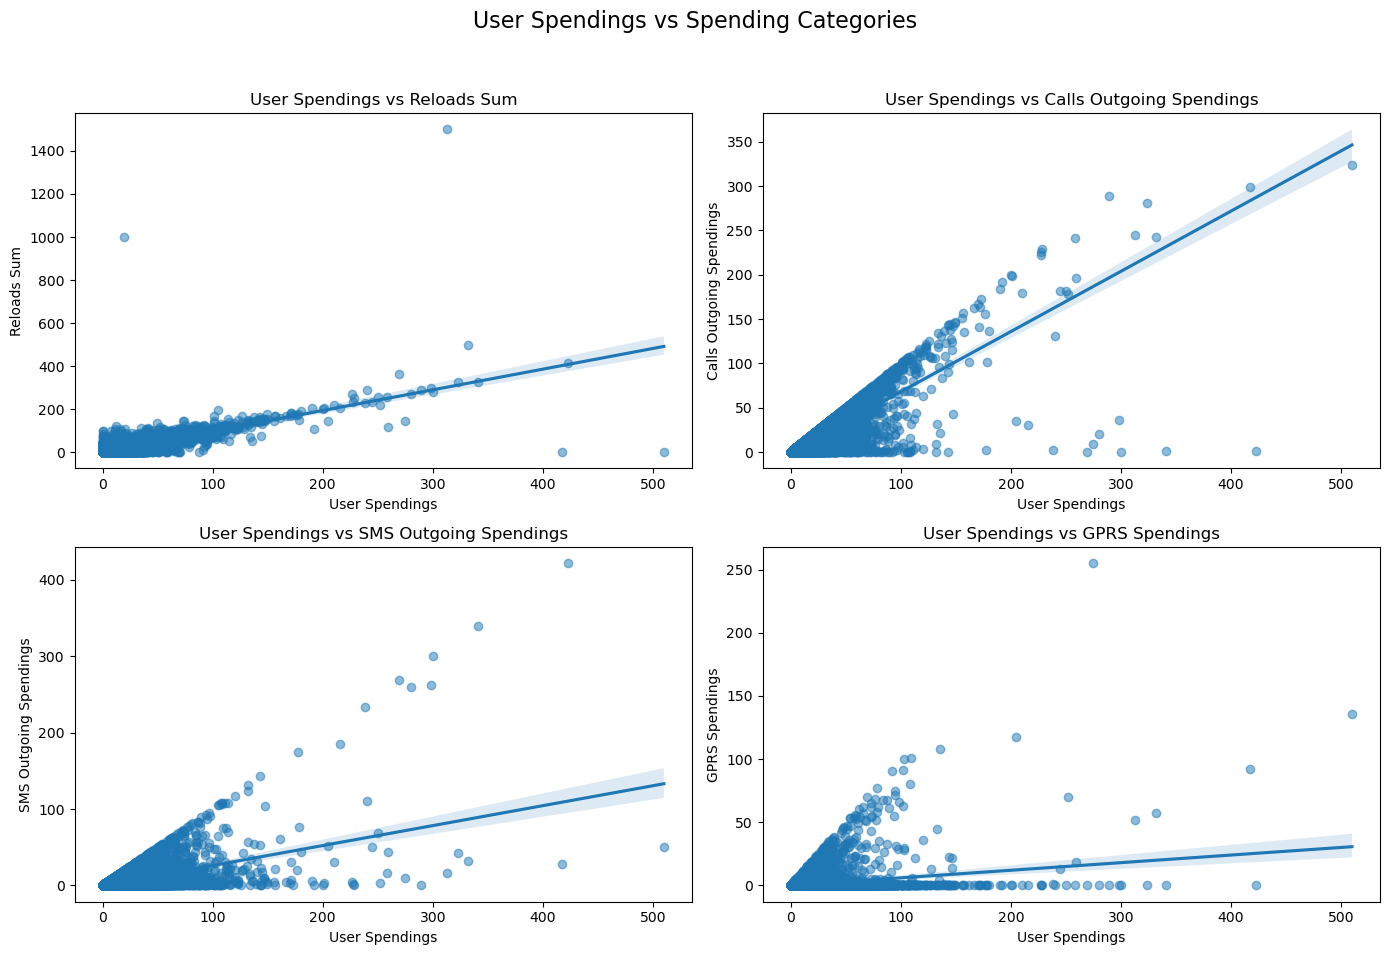

In [63]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("User Spendings vs Spending Categories", fontsize=16)

# User Spendings vs Reloads Sum
sns.regplot(x='user_spendings', y='reloads_sum', data=data, ax=axes[0, 0], scatter_kws={'alpha':0.5})
axes[0, 0].set_title("User Spendings vs Reloads Sum")
axes[0, 0].set_xlabel("User Spendings")
axes[0, 0].set_ylabel("Reloads Sum")

# User Spendings vs Calls Outgoing Spendings
sns.regplot(x='user_spendings', y='calls_outgoing_spendings', data=data, ax=axes[0, 1], scatter_kws={'alpha':0.5})
axes[0, 1].set_title("User Spendings vs Calls Outgoing Spendings")
axes[0, 1].set_xlabel("User Spendings")
axes[0, 1].set_ylabel("Calls Outgoing Spendings")

# User Spendings vs SMS Outgoing Spendings
sns.regplot(x='user_spendings', y='sms_outgoing_spendings', data=data, ax=axes[1, 0], scatter_kws={'alpha':0.5})
axes[1, 0].set_title("User Spendings vs SMS Outgoing Spendings")
axes[1, 0].set_xlabel("User Spendings")
axes[1, 0].set_ylabel("SMS Outgoing Spendings")

# User Spendings vs GPRS Spendings
sns.regplot(x='user_spendings', y='gprs_spendings', data=data, ax=axes[1, 1], scatter_kws={'alpha':0.5})
axes[1, 1].set_title("User Spendings vs GPRS Spendings")
axes[1, 1].set_xlabel("User Spendings")
axes[1, 1].set_ylabel("GPRS Spendings")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

**Focusing on call features could be meaningful...**

### 1.1 CORRELATION ANALYSIS

### **Data Scope & Relevance**

### 📌 **Temporal Scope**

- **Observation Period:** The dataset contains records only from 2013.
- **Data Consistency:** Since no seasonal variation is present (only three distinct months exist), the year information can be safely dropped.

### 📌 **Unique Identifiers**
- **Feature:** `user_account_id`
- **Observation:** With 60,000 (total shape) unique values, this identifier holds no predictive significance for our models.

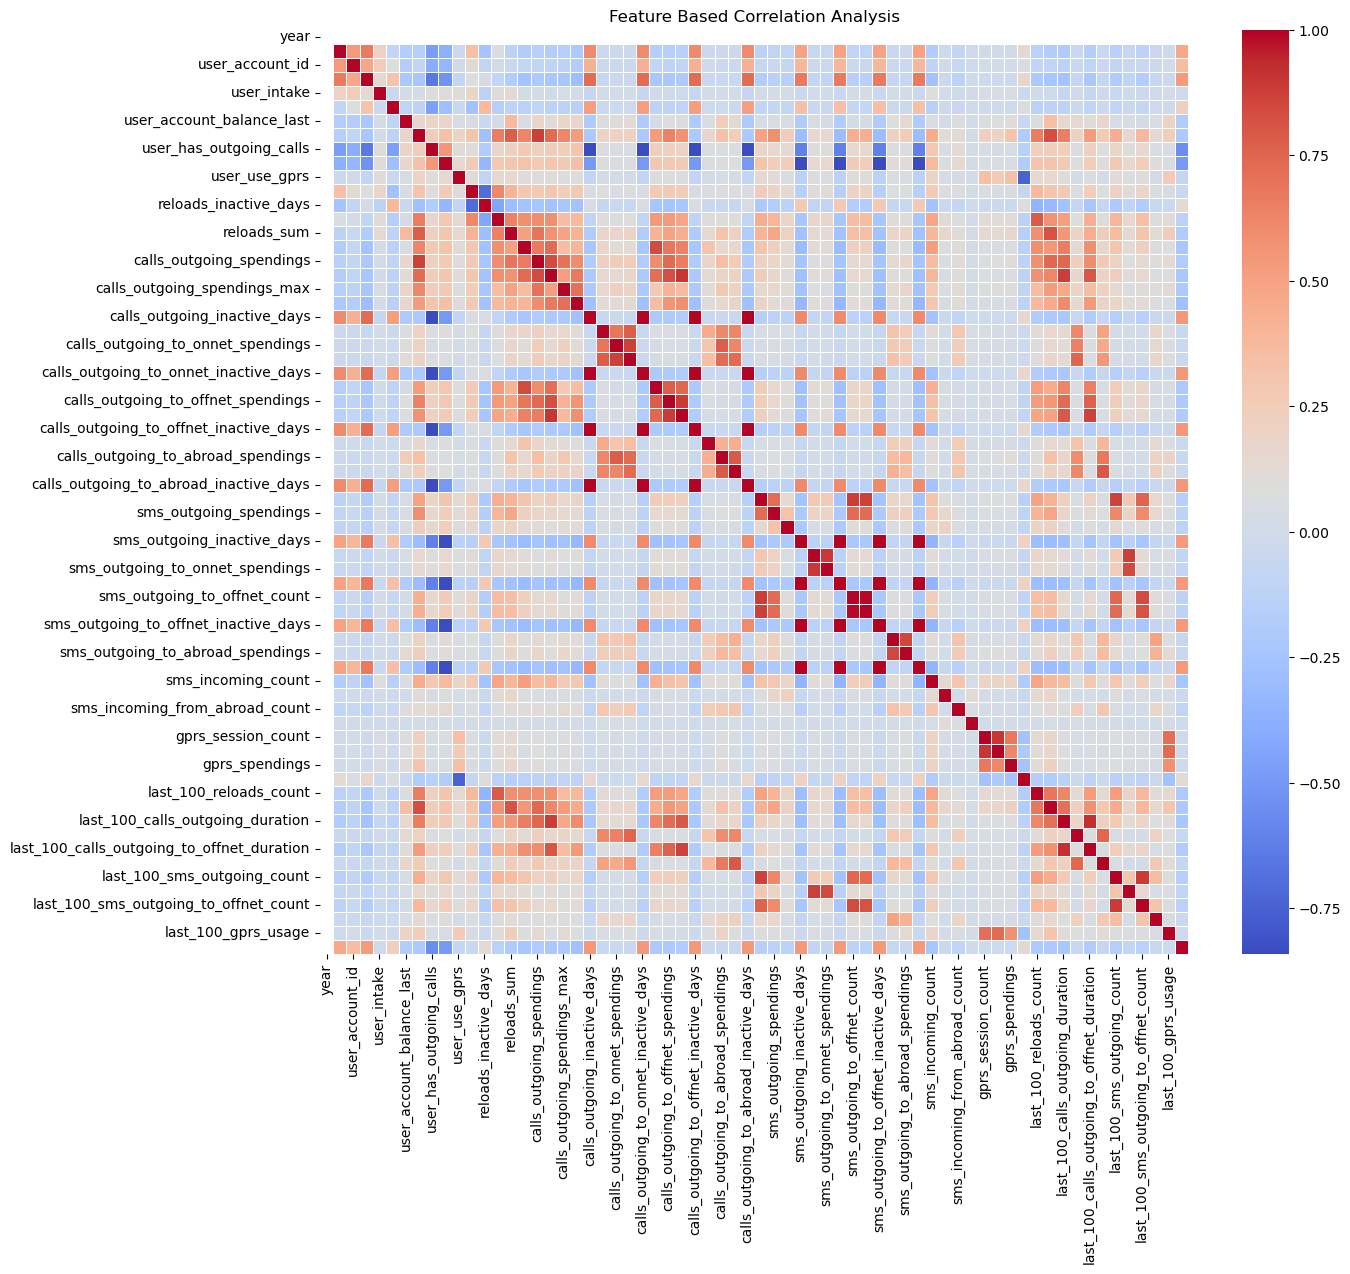

In [64]:
correlation_matrix = data.corr()

plt.figure(figsize=(14, 12))

sns.heatmap(correlation_matrix, 
            annot=False,         
            fmt=".2f",         
            cmap='coolwarm',   
            linewidths=0.5)     

plt.title("Feature Based Correlation Analysis")
plt.show()

churn_corr = correlation_matrix["churn"].drop("churn")

In [65]:
data.year.value_counts()

year
2013    59884
Name: count, dtype: int64

In [66]:
data.drop(columns=["year", "user_account_id"], inplace=True)

In [67]:
data.month.value_counts()

month
6    51917
8     7443
7      524
Name: count, dtype: int64

## 2. FEATURE DERIVATION

- **"The last 100 xxx" features** can be utilized on total usage to calculate intensity features.  
- Calculating averages and extracting user behaviors are key requirements for deriving new features.

In [68]:
data['call_usage_intensity'] = data['last_100_calls_outgoing_duration'] / (data['user_lifetime'] + 1)
data['sms_usage_intensity'] = data['last_100_sms_outgoing_count'] / (data['user_intake'] + 1)


In [69]:
data['call_cost_efficiency'] = data['calls_outgoing_duration'] / (data['calls_outgoing_spendings'] + 1)
data['sms_cost_efficiency'] = data['sms_outgoing_count'] / (data['sms_outgoing_spendings'] + 1)


In [70]:
data[['call_usage_intensity', 'sms_usage_intensity', 'call_cost_efficiency', 'sms_cost_efficiency']].describe()

,call_usage_intensity,sms_usage_intensity,call_cost_efficiency,sms_cost_efficiency
count,59884.000000,59884.000000,59884.000000,59884.000000
mean,0.291997,100.614805,3.778951,7.423356
std,1.049003,264.397263,7.531075,17.853397
min,0.000000,0.000000,0.000000,0.000000
25%,0.000607,0.000000,0.000000,0.000000
50%,0.037173,13.000000,3.750408,2.542373
75%,0.164272,94.000000,5.909327,10.447761
max,49.500000,18637.000000,1297.739130,1821.000000


### 2.1 Ensemble Feature Derivation

#### 📌 **Engagement Score**
- This metric reflects the overall activity level of a user based on their communication behavior.  
- Outgoing calls, outgoing SMS, and GPRS usage are taken into account to 
determine user engagement.  
- Each activity is normalized by the respective user lifetime or intake period to ensure fair comparisons across different users.  
- **Conclusion:** A higher engagement score indicates a more active user, while a lower score suggests limited interaction with the platform.  

In [71]:
data['engagement_score'] = (
    (data['calls_outgoing_count'] / (data['user_lifetime'] + 1)) +
    (data['sms_outgoing_count'] / (data['user_intake'] + 1)) +
    (data['gprs_usage'] / (data['user_lifetime'] + 1))
)

#### 📌 **Channel Diversity**
- This feature captures the variety of communication channels utilized by a user.  
- Different aspects, such as making outgoing calls, sending SMS, using mobile data (GPRS), and performing recharges, are considered.  
- A higher diversity score suggests that a user interacts with multiple communication methods, indicating a well-rounded usage pattern.  
- **Conclusion:** This feature helps in distinguishing between single-channel users and multi-channel users, providing insights into behavioral segmentation.

In [72]:
data['channel_diversity'] = (
    data['user_has_outgoing_calls'] +
    data['user_has_outgoing_sms'] +
    data['user_use_gprs'] +
    data['user_does_reload'])

### Zero Value Analysis in Columns  

> **Note:** `print()` output was too long, so it has been commented out.  

- Checked how many **zero values** exist in each column.  
- Some columns contain **almost entirely zeros**.  
- These columns will be **dropped** during the **correlation filtering** stage.  


In [73]:
zero_counts_per_column = (data == 0).sum()

#print(zero_counts_per_column.sort_values(ascending = False).to_string())

### Correlation of All Features with Churn 

> **Note:** `print()` output was too long, so it has been commented out. 

Below is the correlation of all columns with **churn**. This helps identify which features have a strong or weak relationship with churn, guiding feature selection and model optimization.  


In [74]:
#print(churn_corr.sort_values(ascending=False).to_string())

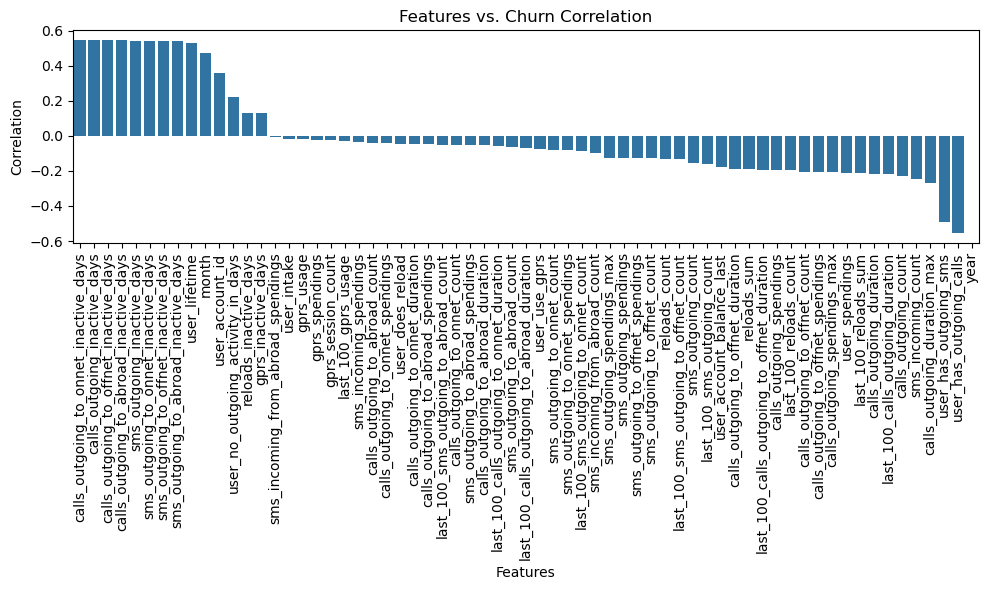

In [75]:
churn_corr_sorted = churn_corr.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=churn_corr_sorted.index, y=churn_corr_sorted.values)

plt.xticks(rotation=90)
plt.title('Features vs. Churn Correlation')
plt.xlabel('Features')
plt.ylabel('Correlation')
plt.tight_layout()
plt.show()


### Channel Diversity vs. Churn Distribution  

- This analysis examines the distribution of **churn** based on the **channel diversity** feature using a **bar plot**.  
- Since **channel diversity** is an **ensemble feature** (aggregated from multiple columns), it may play a **key role** in the model's predictions.  


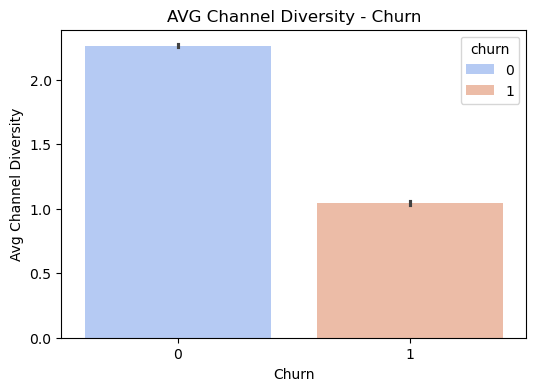

In [76]:
plt.figure(figsize=(6,4))
sns.barplot(x='churn', y='channel_diversity', data=data, palette='coolwarm', hue='churn')
plt.title("AVG Channel Diversity - Churn")
plt.xlabel("Churn")
plt.ylabel("Avg Channel Diversity")
plt.show()

In [77]:
data['channel_diversity'].value_counts()

channel_diversity
3    22512
2    15172
1    14488
0     5702
4     2010
Name: count, dtype: int64

### Feature Engineering: Inactivity & Financial Health  

- **`inactivity_ratio`**:  
  - Measures the proportion of inactive days relative to the user's total lifetime. The `+1` avoids division by zero.  

- **`inactivity_alert`**:  
  - Binary Transformation of **inactivity_ratio**

- **`financial_health`**:  
  - Represents the user’s financial status by combining **account balance, reloads, and spending**.  
  - Higher values suggest **better financial stability**, while negative values may indicate financial distress.  

These engineered features can provide valuable signals for **churn prediction**.  


In [78]:
data['inactivity_ratio'] = data['user_no_outgoing_activity_in_days'] / (data['user_lifetime'] + 1)
data['inactivity_alert'] = (data['inactivity_ratio'] > 0.5).astype(int)

data['financial_health'] = (data['user_account_balance_last'] + data['reloads_sum'] - data['user_spendings'])

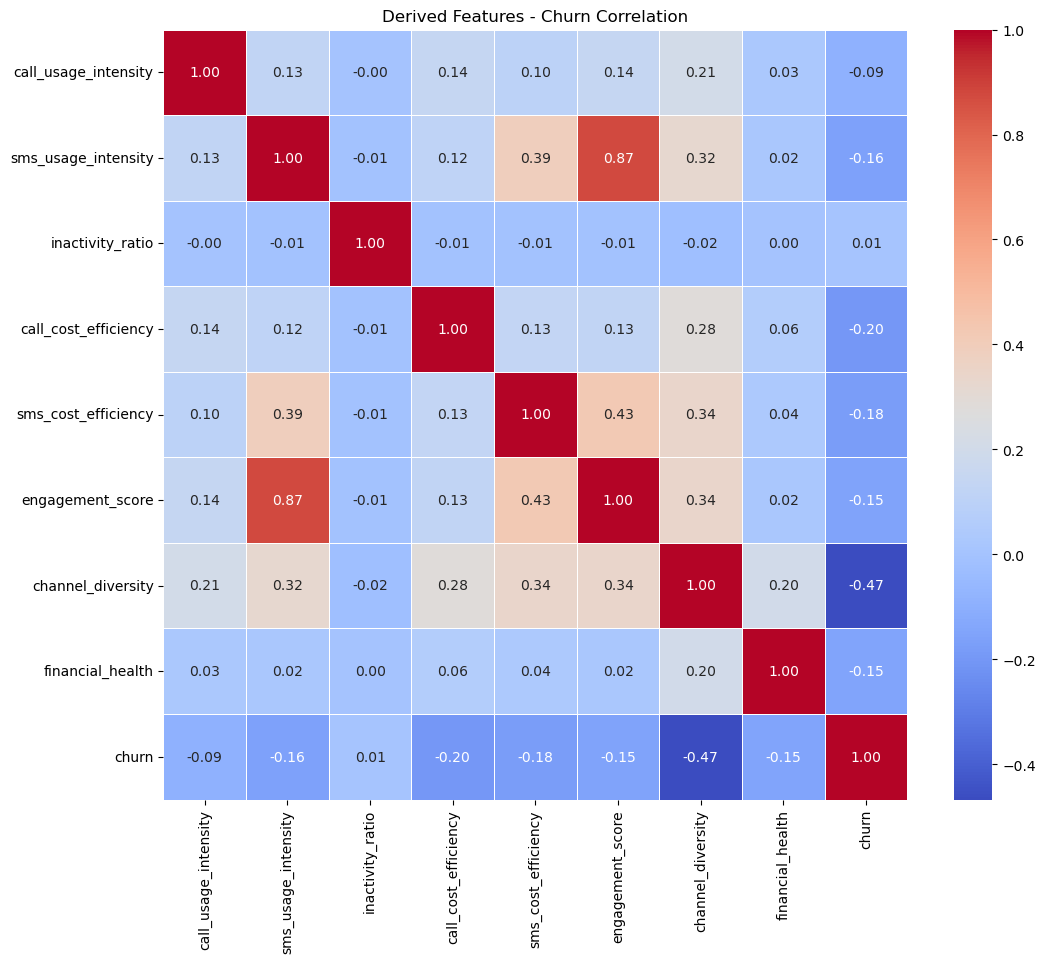

In [79]:
derived_features = ['call_usage_intensity', 'sms_usage_intensity', 'inactivity_ratio',
                    'call_cost_efficiency', 'sms_cost_efficiency', 'engagement_score',
                    'channel_diversity', 'financial_health', 'churn']

plt.figure(figsize=(12,10))
corr_matrix = data[derived_features].corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Derived Features - Churn Correlation")
plt.show()

In [80]:
data.shape

(59884, 73)

### Churn Correlation Filtering  

#### How It Works:
1. **Computes the correlation matrix** of the dataset.  
2. **Extracts absolute correlations** of all features with the target variable (`churn`).  
3. **Removes features** with a correlation below the given `threshold`. Setted as 0.05 through **churn_corr_sorted**.
4. Returns a **list of low-correlation features** to be dropped.  

#### Why Is This Important?
- Helps in **feature selection** by removing irrelevant variables.  
- Reduces **dimensionality** and potential noise in the model.  
- Improves model efficiency without losing significant predictive power.  

The identified **low-correlation features** will be **excluded** from the final modeling process.  


In [81]:
def churn_correlation_filter(df, target="churn", threshold=0.05):
    corr_matrix = df.corr()
    churn_corr = corr_matrix[target].abs().drop(target)  
    to_drop = churn_corr[churn_corr < threshold].index.tolist() 
    return to_drop

low_corr_features = churn_correlation_filter(data, target="churn", threshold=0.05)

print("Features with low correlation to churn:", low_corr_features)

Features with low correlation to churn: ['user_intake', 'user_does_reload', 'calls_outgoing_to_onnet_spendings', 'calls_outgoing_to_onnet_duration', 'calls_outgoing_to_abroad_count', 'calls_outgoing_to_abroad_spendings', 'sms_incoming_spendings', 'sms_incoming_from_abroad_spendings', 'gprs_session_count', 'gprs_usage', 'gprs_spendings', 'last_100_gprs_usage', 'inactivity_ratio']


In [82]:
X = data.drop('churn', axis=1)
y = data['churn']

## 3. CORRELATION FILTERING METHOD

### High Correlation Filtering  

**First, a basic correlation filtering method is applied to eliminate highly correlated features.**  
This method removes one of the columns that have a very high correlation with each other to prevent **multicollinearity** and improve model performance.  

#### How It Works
1. **Computes the absolute correlation matrix** of the dataset.  
2. **Identifies highly correlated feature pairs** using an upper triangular matrix to avoid duplicate checks.  
3. **Drops one feature** from each highly correlated pair if correlation > `threshold` (default = **0.95**).  

#### Why Is This Important?
- Prevents **redundant features** from affecting model performance.  
- Reduces **overfitting** and improves model **generalization**.  
- Makes the dataset **more efficient** without losing significant information.  

After filtering, only the **most relevant features** remain for modeling.  


In [83]:
def correlation_filter(df, threshold=0.9):
    
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    return to_drop

features_to_drop = correlation_filter(X, threshold=0.95)
print("Features to drop:", features_to_drop)

X_filtered = X.drop(columns=features_to_drop)

Features to drop: ['calls_outgoing_to_onnet_inactive_days', 'calls_outgoing_to_offnet_inactive_days', 'calls_outgoing_to_abroad_inactive_days', 'sms_outgoing_to_onnet_inactive_days', 'sms_outgoing_to_offnet_spendings', 'sms_outgoing_to_offnet_inactive_days', 'sms_outgoing_to_abroad_inactive_days', 'sms_usage_intensity', 'engagement_score']


In [84]:
X_filtered = X_filtered.drop(columns=low_corr_features)

## 4. SCALING AND ENCODING FEATURES

### Feature Scaling & Encoding  

- **Numeric features** are standardized using **StandardScaler**.  
- **Categorical features** are encoded using **LabelEncoder**.  
- Prepares the data for modeling by ensuring consistency in feature values.  

In [85]:
cat_features = ['month', 'user_has_outgoing_calls', 'user_has_outgoing_sms','inactivity_alert']
num_features = [col for col in X_filtered.columns if col not in cat_features + ['churn']]

scaler = StandardScaler()
X_filtered[num_features] = scaler.fit_transform(X_filtered[num_features])

label_encoders = {}
for col in cat_features:
    le = LabelEncoder()
    X_filtered[col] = le.fit_transform(X_filtered[col])
    label_encoders[col] = le


In [32]:
data.churn.value_counts()

churn
0    47348
1    12536
Name: count, dtype: int64

**Train, Test and Validation sets. I splitted them as %70 train, %20 test and %10 for validation - evalulation set**

In [33]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_filtered, y, test_size=0.1, stratify=y, random_state=42
)

# validation = 10/80 = 0.125
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.125, stratify=y_train_val, random_state=42
)

print(f"Train set: {X_train.shape}, Validation set: {X_val.shape}, Test set: {X_test.shape}")

Train set: (47158, 50), Validation set: (6737, 50), Test set: (5989, 50)


"""from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

undersampler = RandomUnderSampler(sampling_strategy=0.4, random_state=42)

X_train, y_train = undersampler.fit_resample(X_train, y_train)"""

### Handling Imbalanced Data with Undersampling  

- **RandomUnderSampler** was applied to balance the dataset with a **0.4 sampling ratio**.  
- However, due to the **dataset size**, this did not significantly improve model performance.  

### Why Not Oversampling?  
- **SMOTE** and similar oversampling techniques were **not used** because generating synthetic data may lead to **unrealistic patterns** in real-life scenarios.  


In [34]:
y_train.value_counts()

churn
0    37286
1     9872
Name: count, dtype: int64

In [35]:
y_test.value_counts()

churn
0    4735
1    1254
Name: count, dtype: int64

In [36]:
y_val.value_counts()

churn
0    5327
1    1410
Name: count, dtype: int64

## 5. MODELING & FIRST INSIGHTS ON LR AND RF MODELS

In [37]:
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    labels = ['Not Churn', 'Churn']

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=labels, yticklabels=labels, linewidths=1, linecolor='black')

    plt.xlabel("Predicted Label", fontsize=12)
    plt.ylabel("True Label", fontsize=12)
    plt.title("Confusion Matrix", fontsize=14)
    plt.show()

### Modeling & Stacked Classifier Approach

- **RandomForest (RF)** and **Logistic Regression (LogReg)** were tested as individual models.  
- **LogReg** performed well in terms of **churn recall** (capturing churn cases).  
- **RF** showed strong performance in **churn precision** (reducing false positives).  
- To leverage the strengths of both models, a **Stacked Classifier** was built using **CatBoost** as the **meta-model**.  

*RandomForest's initial results are attached as a screenshot.*  


In [38]:
lr_model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
lr_model.fit(X_train, y_train)

y_pred = lr_model.predict(X_test)
y_proba = lr_model.predict_proba(X_test)[:, 1]

print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("ROC-AUC Skoru:", roc_auc_score(y_test, y_proba))



Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.84      0.89      4735
           1       0.58      0.84      0.69      1254

    accuracy                           0.84      5989
   macro avg       0.77      0.84      0.79      5989
weighted avg       0.88      0.84      0.85      5989

ROC-AUC Skoru: 0.9084776234528917


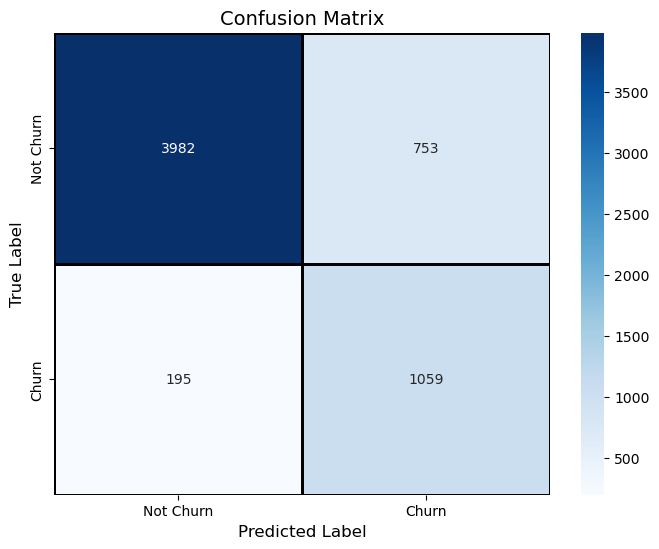

In [39]:
plot_confusion_matrix(y_test, y_pred)

**THIS IS THE INITIAL MODEL RESULTS, THIS RESULT DOES NOT CONTAIN DERIVED FEATURES**

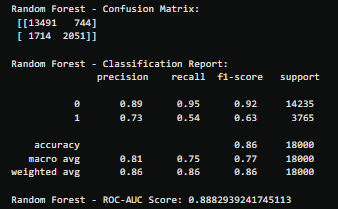

In [40]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=500, class_weight='balanced', random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]

print("\nRandom Forest - Classification Report:\n", classification_report(y_test, y_pred_rf))
print("Random Forest - ROC-AUC Score:", roc_auc_score(y_test, y_proba_rf))



Random Forest - Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.92      0.92      4735
           1       0.70      0.68      0.69      1254

    accuracy                           0.87      5989
   macro avg       0.81      0.80      0.80      5989
weighted avg       0.87      0.87      0.87      5989

Random Forest - ROC-AUC Score: 0.9132085878515046


**almost 0.1 better. I will use GridSearch on different models like boosting models, SVM with SCV (Stratified Cross Validation) data to obtain nearly best performance. And for last step, It's logical to use optıuna on catboost or xgboost, we can use them for an ensemble solution**

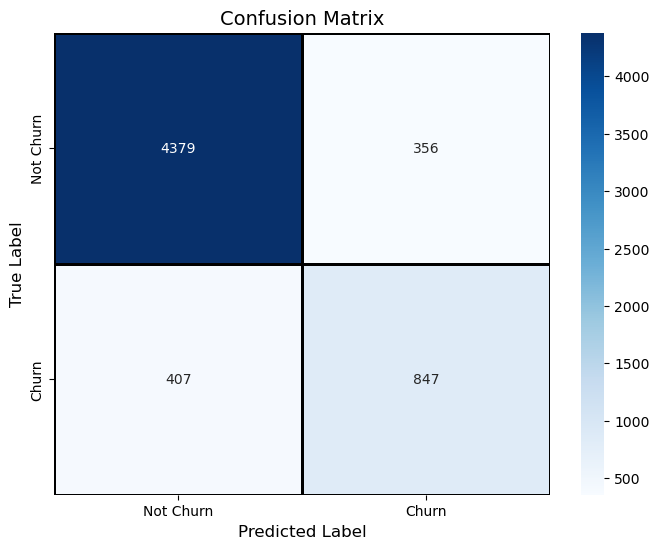

In [41]:
plot_confusion_matrix(y_test, y_pred_rf)

In [42]:
from sklearn.ensemble import StackingClassifier
from sklearn.utils.class_weight import compute_class_weight

estimators = [
    ('rf_inital', rf_model),  
    ('logistic_reg_inital', lr_model)
]

classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)

# It's for Catboost algorithm
catboost_class_weights = list(class_weights)

model = CatBoostClassifier(
    iterations=2000,
    learning_rate=0.05,
    depth=8,
    loss_function='Logloss',
    eval_metric='Precision',       
    random_seed=42,
    verbose=100,
    class_weights=catboost_class_weights
)

stacking_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=model, 
    cv=5,
    passthrough=True,
    n_jobs=-1
)

stacking_clf.fit(X_train, y_train)


0:	learn: 0.8311739	total: 176ms	remaining: 5m 51s
100:	learn: 0.8538795	total: 2.75s	remaining: 51.7s
200:	learn: 0.8604349	total: 5.53s	remaining: 49.5s
300:	learn: 0.8710049	total: 8.24s	remaining: 46.5s
400:	learn: 0.8775573	total: 11s	remaining: 43.8s
500:	learn: 0.8851601	total: 13.7s	remaining: 41s
600:	learn: 0.8923959	total: 16.5s	remaining: 38.3s
700:	learn: 0.8965434	total: 19.2s	remaining: 35.5s
800:	learn: 0.9001813	total: 21.8s	remaining: 32.6s
900:	learn: 0.9033672	total: 24.5s	remaining: 29.9s
1000:	learn: 0.9065203	total: 27.2s	remaining: 27.2s
1100:	learn: 0.9095062	total: 29.9s	remaining: 24.4s
1200:	learn: 0.9126331	total: 32.5s	remaining: 21.6s
1300:	learn: 0.9148381	total: 35.2s	remaining: 18.9s
1400:	learn: 0.9165902	total: 37.9s	remaining: 16.2s
1500:	learn: 0.9186445	total: 40.6s	remaining: 13.5s
1600:	learn: 0.9202698	total: 43.4s	remaining: 10.8s
1700:	learn: 0.9219955	total: 46.2s	remaining: 8.12s
1800:	learn: 0.9235494	total: 49s	remaining: 5.41s
1900:	lear

StackingClassifier(cv=5,
                   estimators=[('rf_inital',
                                RandomForestClassifier(class_weight='balanced',
                                                       n_estimators=500,
                                                       random_state=42)),
                               ('logistic_reg_inital',
                                LogisticRegression(class_weight='balanced',
                                                   max_iter=1000,
                                                   random_state=42))],
                   final_estimator=<catboost.core.CatBoostClassifier object at 0x0000023BEEDAB9A0>,
                   n_jobs=-1, passthrough=True)

In [43]:
X_test_concat = pd.concat([X_val, X_test], ignore_index=True)

y_test_concat = pd.concat([y_val, y_test], ignore_index=True)

#### Stacking Model Results

In [44]:
from sklearn.metrics import precision_recall_curve, auc

y_pred = stacking_clf.predict(X_test_concat)
y_proba = stacking_clf.predict_proba(X_test_concat)[:, 1]
test_auc = roc_auc_score(y_test_concat, y_proba)
precision, recall, _ = precision_recall_curve(y_test_concat, y_proba)
pr_auc = auc(recall, precision)

print("\nStacked Initial - Classification Report:\n", classification_report(y_test_concat, y_pred))
print("Stacked Initial - ROC-AUC Score:", roc_auc_score(y_test_concat, y_proba))
print("Stacked Initial - Precision-Recall Score:", pr_auc)


Stacked Initial - Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.89      0.91     10062
           1       0.66      0.77      0.71      2664

    accuracy                           0.87     12726
   macro avg       0.80      0.83      0.81     12726
weighted avg       0.88      0.87      0.87     12726

Stacked Initial - ROC-AUC Score: 0.9032819342896863
Stacked Initial - Precision-Recall Score: 0.7511782513207799


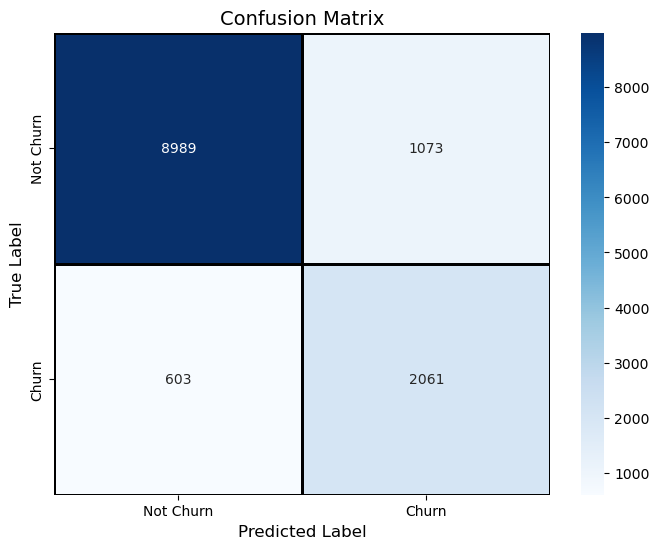

In [45]:
plot_confusion_matrix(y_test_concat, y_pred)

### Model Performance: Stacked Model

#### 🔹 **ROC Curve (Receiver Operating Characteristic)**
- The **ROC curve** evaluates the model’s ability to distinguish between classes.
- The **True Positive Rate (Recall)** is plotted against the **False Positive Rate**.
- AUC (**Area Under the Curve**) = **0.90**, indicating strong classification performance.

#### 🔹 **Precision-Recall Curve**
- Shows the tradeoff between **Precision** and **Recall**.
- As **recall increases**, **precision decreases**, reflecting the model's confidence in predictions.
- Helps assess model effectiveness in **imbalanced datasets**, especially for churn detection.


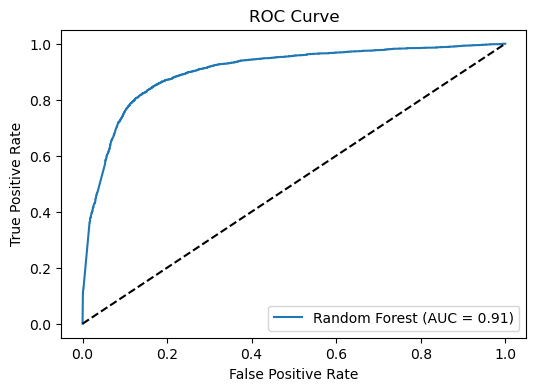

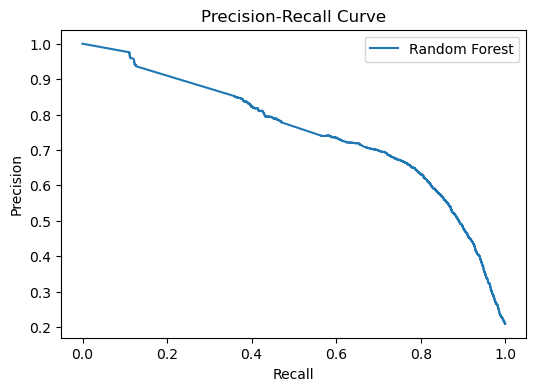

In [46]:
from sklearn.metrics import roc_curve, precision_recall_curve

fpr, tpr, _ = roc_curve(y_test_concat, y_proba)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label='Random Forest (AUC = %0.2f)' % roc_auc_score(y_test, y_proba_rf))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

precision, recall, _ = precision_recall_curve(y_test_concat, y_proba)
plt.figure(figsize=(6,4))
plt.plot(recall, precision, label='Random Forest')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()


The **precision-recall tradeoff** was balanced, leading to a more **effective churn detection model**.  

### Why Precision & Recall Matter in Churn Detection?  
- **High recall** ensures we **identify** most churn cases, preventing missed churners.  
- **High precision** minimizes **false churn predictions**, avoiding unnecessary retention efforts.  
- A **balanced tradeoff** ensures **optimal decision-making** in churn prevention strategies.  

#### Initial RF Model Feature Importances

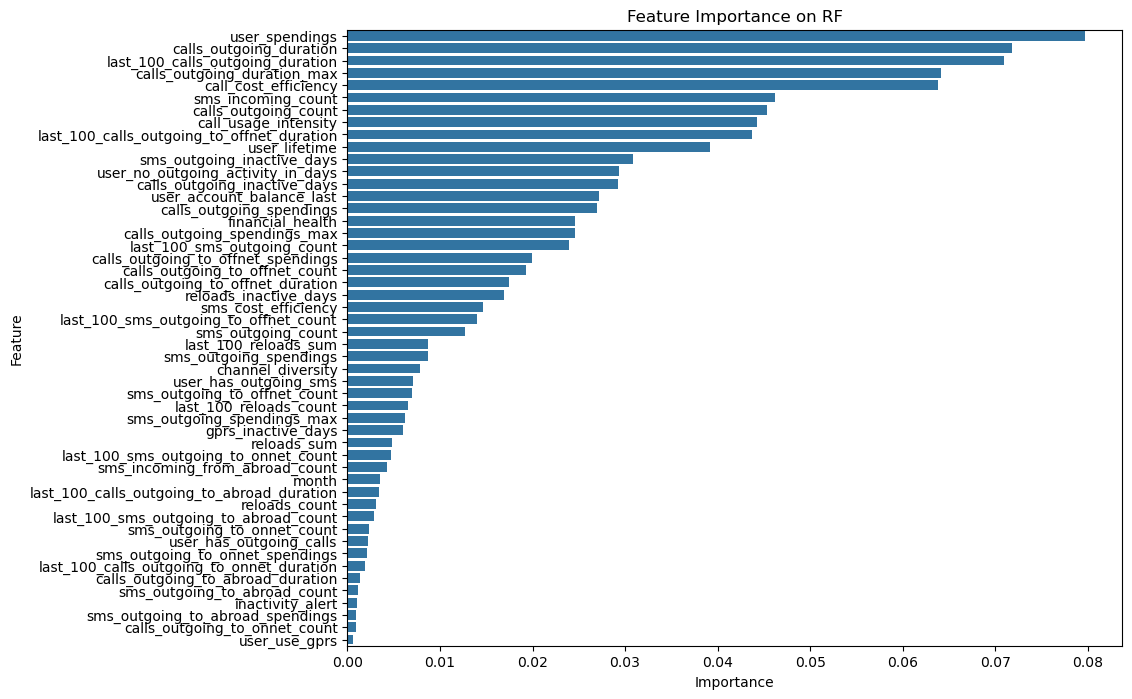

In [47]:
importances = rf_model.feature_importances_
features = X_filtered.columns

feature_importance_df = pd.DataFrame({
    'feature': features,
    'importance': importances
}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(10,8))
sns.barplot(x='importance', y='feature', data=feature_importance_df)
plt.title("Feature Importance on RF")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()


**There, we can clearly see some of the features that we derived directly influences the model. That could be a good transmitter.**

In [48]:
feature_importance_df.head(15).feature.tolist()

['user_spendings',
 'calls_outgoing_duration',
 'last_100_calls_outgoing_duration',
 'calls_outgoing_duration_max',
 'call_cost_efficiency',
 'sms_incoming_count',
 'calls_outgoing_count',
 'call_usage_intensity',
 'last_100_calls_outgoing_to_offnet_duration',
 'user_lifetime',
 'sms_outgoing_inactive_days',
 'user_no_outgoing_activity_in_days',
 'calls_outgoing_inactive_days',
 'user_account_balance_last',
 'calls_outgoing_spendings']

**The importance levels trying to tell us something. The feature that I derived 'inactivity_ratio' is something important, but we can't say the same thing on 'inactivity_alert' maybe it's not a good idea to binarize it.**

**To tackle class imbalance, class_weight methodology is commonly used. There are two different class weight definition to use them in regarding algorithm, total data contains %20 churn, %80 non-churn values**

In [49]:
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

## 6. GRIDSEARCH VIA SKF

### Further Optimization & Model Selection  

**There, it's still not satisfactory. Using class weights was okay, but it didn't change the overall performance much. Maybe, it's time to optimize the feature set again, but also, trying other modeling/optimization techniques is crucial.**  

- To improve performance, **Stratified Cross-Validation** was applied with **Grid Search** across:  
  - **CatBoost**  
  - **XGBoost**  
  - **LightGBM**  

- Additionally, **Optuna** was used to fine-tune **CatBoost** via a structured **hyperparameter study**, aiming for optimal model performance.  


In [50]:
param_grid_xgb = {
    'clf__n_estimators': [600, 1000],
    'clf__max_depth': [3, 6, 8],
    'clf__learning_rate': [0.01, 0.1],
    'clf__scale_pos_weight': [scale_pos_weight]
}
param_grid_cat = {
    'clf__iterations': [400, 600, 800],
    'clf__depth': [4, 6, 8],
    'clf__learning_rate': [0.01, 0.1],
    'clf__class_weights': [catboost_class_weights] 
}
param_grid_lgb = {
    'clf__n_estimators': [200, 400],
    'clf__max_depth': [3, 6, -1],
    'clf__learning_rate': [0.01, 0.1],
    'clf__class_weight': ['balanced']
}

models = {
    'XGBoost': (XGBClassifier(objective="binary:logistic", eval_metric='auc', random_state=42), param_grid_xgb),
    'CatBoost': (CatBoostClassifier(verbose=0, random_seed=42), param_grid_cat),
    'LightGBM': (LGBMClassifier(verbose=-1, random_state=42), param_grid_lgb)
}


### Advantages of Using StratifiedKFold  

- Ensures **class distribution** remains balanced across all folds.  
- Prevents bias in **imbalanced datasets**, improving model reliability.  
- Leads to **more stable** performance evaluation by reducing variance.  
- Helps optimize models **without overfitting** to specific data splits.  

In [51]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

best_models = {}
cv_results = {}

for name, (model, grid) in models.items():
    print(f"\nGridSearchCV for {name}...")
    pipeline = Pipeline([
        ('clf', model)
    ])
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=grid,
        scoring='roc_auc',
        cv=skf,
        verbose=1
    )
    grid_search.fit(X_train, y_train)
    best_models[name] = grid_search.best_estimator_
    cv_results[name] = grid_search.best_score_
    print(f"{name} Best CV ROC-AUC: {grid_search.best_score_:.4f}")
    print(f"{name} Best Params: {grid_search.best_params_}\n")
    
best_model_name = max(cv_results, key=cv_results.get)
print("Best Model on SKF:", best_model_name, "ROC-AUC:", cv_results[best_model_name])



GridSearchCV for XGBoost...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
XGBoost Best CV ROC-AUC: 0.9085
XGBoost Best Params: {'clf__learning_rate': 0.01, 'clf__max_depth': 6, 'clf__n_estimators': 600, 'clf__scale_pos_weight': 3.77694489465154}


GridSearchCV for CatBoost...
Fitting 5 folds for each of 18 candidates, totalling 90 fits
CatBoost Best CV ROC-AUC: 0.9090
CatBoost Best Params: {'clf__class_weights': [0.6323821273400204, 2.38847244732577], 'clf__depth': 6, 'clf__iterations': 800, 'clf__learning_rate': 0.01}


GridSearchCV for LightGBM...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
LightGBM Best CV ROC-AUC: 0.9093
LightGBM Best Params: {'clf__class_weight': 'balanced', 'clf__learning_rate': 0.01, 'clf__max_depth': -1, 'clf__n_estimators': 400}

Best Model on SKF: LightGBM ROC-AUC: 0.9092858185340115


In [52]:
best_clf = best_models[best_model_name].named_steps['clf']
best_clf.fit(X_train, y_train, 
             eval_set=[(X_val, y_val)])

    
y_pred = best_clf.predict(X_test)
y_proba = best_clf.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, y_proba)

print("\nTest Set ROC-AUC:", test_auc)
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Test Set ROC-AUC: 0.919226837372783

Confusion Matrix:
[[4027  708]
 [ 182 1072]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.85      0.90      4735
           1       0.60      0.85      0.71      1254

    accuracy                           0.85      5989
   macro avg       0.78      0.85      0.80      5989
weighted avg       0.88      0.85      0.86      5989



In [ ]:
plot_confusion_matrix(y_test, y_pred)

## 7. OPTUNA FOR CATBOOST

### Importance of Using Optuna for Hyperparameter Optimization  

- **Automates hyperparameter tuning**, reducing manual effort.  
- Uses **Bayesian Optimization**, making the search more efficient than grid/random search.  
- **Stratified K-Fold CV** ensures reliable model evaluation.  
- Maximizes **ROC-AUC**, leading to a more optimized and generalizable model.  
- Helps find the best **CatBoost hyperparameters**, improving performance in churn detection.  


In [91]:
import optuna

def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 500, 1000),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.3, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-2, 10.0, log=True),
        'random_seed': 42,
        'verbose': 0,
        'eval_metric': 'AUC',
        'class_weights': catboost_class_weights
    }
    model = CatBoostClassifier(**params)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    # cross_val_score returns an array of scores from each fold; we take the mean ROC-AUC
    score = cross_val_score(model, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1).mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print("Optuna - Optimized Hyperparams:")
print(study.best_params)
print("Best CV ROC-AUC:", study.best_value)

best_catboost = CatBoostClassifier(**study.best_params,
                                     random_seed=42,
                                     eval_metric='AUC',
                                     verbose=0)
best_catboost.fit(X_train, y_train)


[I 2025-02-07 01:23:10,212] A new study created in memory with name: no-name-63ee5b9b-6a49-44b9-8c21-d880e1006372
[I 2025-02-07 01:23:29,390] Trial 0 finished with value: 0.9059954977241432 and parameters: {'iterations': 959, 'depth': 7, 'learning_rate': 0.04288323246679897, 'l2_leaf_reg': 4.637673273339809}. Best is trial 0 with value: 0.9059954977241432.
[I 2025-02-07 01:24:56,705] Trial 1 finished with value: 0.9050481558465346 and parameters: {'iterations': 781, 'depth': 10, 'learning_rate': 0.0031763463370620814, 'l2_leaf_reg': 0.043017896373509265}. Best is trial 0 with value: 0.9059954977241432.
[I 2025-02-07 01:25:21,920] Trial 2 finished with value: 0.8922160403438891 and parameters: {'iterations': 894, 'depth': 8, 'learning_rate': 0.1482102690691626, 'l2_leaf_reg': 0.3574025593532144}. Best is trial 0 with value: 0.9059954977241432.
[I 2025-02-07 01:25:38,117] Trial 3 finished with value: 0.8907834869285314 and parameters: {'iterations': 572, 'depth': 8, 'learning_rate': 0.09

Optuna - Optimized Hyperparams:
{'iterations': 844, 'depth': 5, 'learning_rate': 0.012835738498935864, 'l2_leaf_reg': 0.08507980690351506}
Best CV ROC-AUC: 0.9088349363158146


### CatBoost Model Results

In [92]:
y_pred = best_catboost.predict(X_test)
y_proba = best_catboost.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, y_proba)

print("\nTest Set ROC-AUC:", test_auc)
print("\nClassification Report for Catboost Optuna:")
print(classification_report(y_test, y_pred))


Test Set ROC-AUC: 0.9200231066290089

Classification Report for Catboost Optuna:
              precision    recall  f1-score   support

           0       0.92      0.93      0.92      4735
           1       0.72      0.68      0.70      1254

    accuracy                           0.88      5989
   macro avg       0.82      0.80      0.81      5989
weighted avg       0.87      0.88      0.88      5989



**This is the best classification report obtained with Optuna Catboost. Even outperforms the Stacked model.**

**Save Model and other artifacts**

In [99]:
import joblib

joblib.dump(scaler, 'scaler.joblib')
joblib.dump(label_encoders, 'label_encoders.joblib')

best_catboost.save_model("catboost_model.json", format="json")

**Model Usage**

To make predictions using the trained **Stacked Classifier**, follow these steps:

```python
import joblib
from catboost import CatBoostClassifier

catboost_model = CatBoostClassifier()
catboost_model.load_model("catboost_model.json", format="json")

scaler = joblib.load('scaler.joblib')
label_encoders = joblib.load('label_encoders.joblib')
X_test[num_features] = scaler.transform(X_test[num_features])

for col in cat_features:
    X_test[col] = label_encoders[col].transform(X_test[col])

y_pred = catboost_model.predict(X_test)

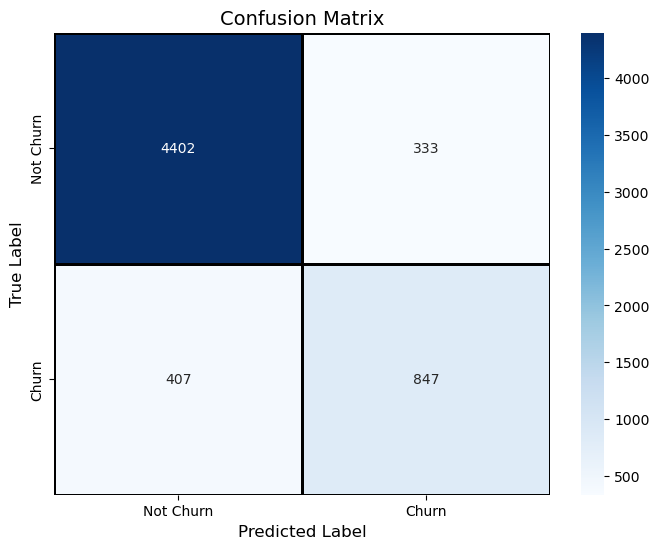

In [93]:
plot_confusion_matrix(y_test, y_pred)

### Feature Importance in Optimized CatBoost Model  

- The **feature importance plot** helps interpret which features contribute the most to the **Optuna-optimized CatBoost model**.  
- **Derived features** show strong significance, validating their relevance in churn prediction.  
- High-importance features indicate **strong predictive power**, while low-importance features may be **redundant**.  
- This analysis helps refine the feature set, improving model efficiency and interpretability.  


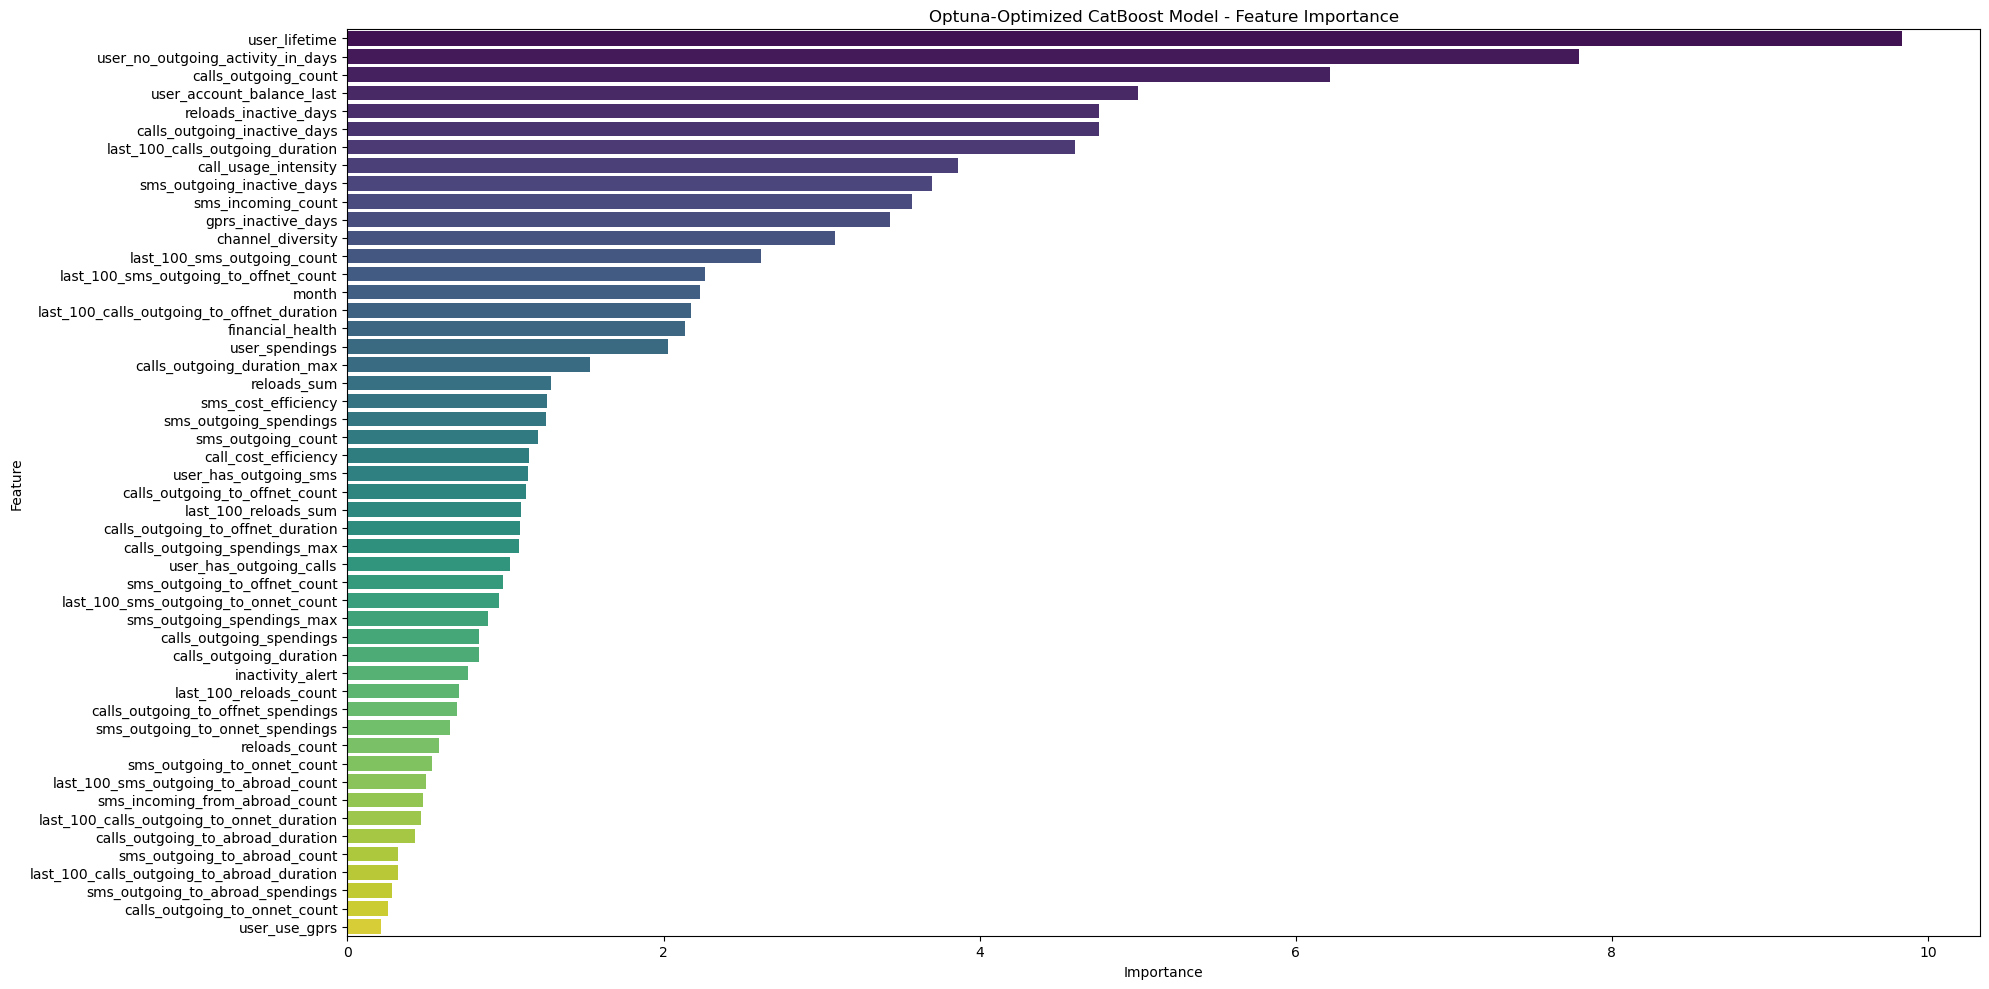

In [96]:
importances = best_catboost.get_feature_importance()
feature_names = X_train.columns
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(20, 10))
sns.barplot(x='importance', y='feature', data=importance_df, palette='viridis', hue='feature')
plt.title("Optuna-Optimized CatBoost Model - Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


###  SHAP Feature Importance & Impact Analysis  

This SHAP (SHapley Additive Explanations) summary plot provides insights into how each feature influences the **churn prediction model**.

####  Key Observations:
- **Feature Importance:**  
  - Features are ranked by their importance in the model.  
  - **"calls_outgoing_count"**, **"user_account_balance_last"**, and **"sms_outgoing_inactive_days"** are among the most impactful features.  

- **Impact on Predictions:**  
  - Each point represents a sample, with **red** indicating high feature values and **blue** indicating low values.  
  - Features like **"financial_health"** and **"inactivity_ratio"** show a strong impact, where higher values tend to **increase churn probability**.

- **Feature Behavior:**  
  - Features like **"calls_outgoing_inactive_days"** and **"user_no_outgoing_activity_in_days"** show a clear trend where higher values contribute to higher churn likelihood.  
  - **"channel_diversity"** and **"call_usage_intensity"** also show noticeable impact patterns.  

#### Why Is This Important?
- Helps interpret **which features drive churn** and how they interact with predictions.  
- Provides a **transparent** view into model decision-making, improving trust in AI-driven churn analysis.  
- Allows for **business actions**, such as targeting users with high inactivity risk or financial instability for retention efforts.  


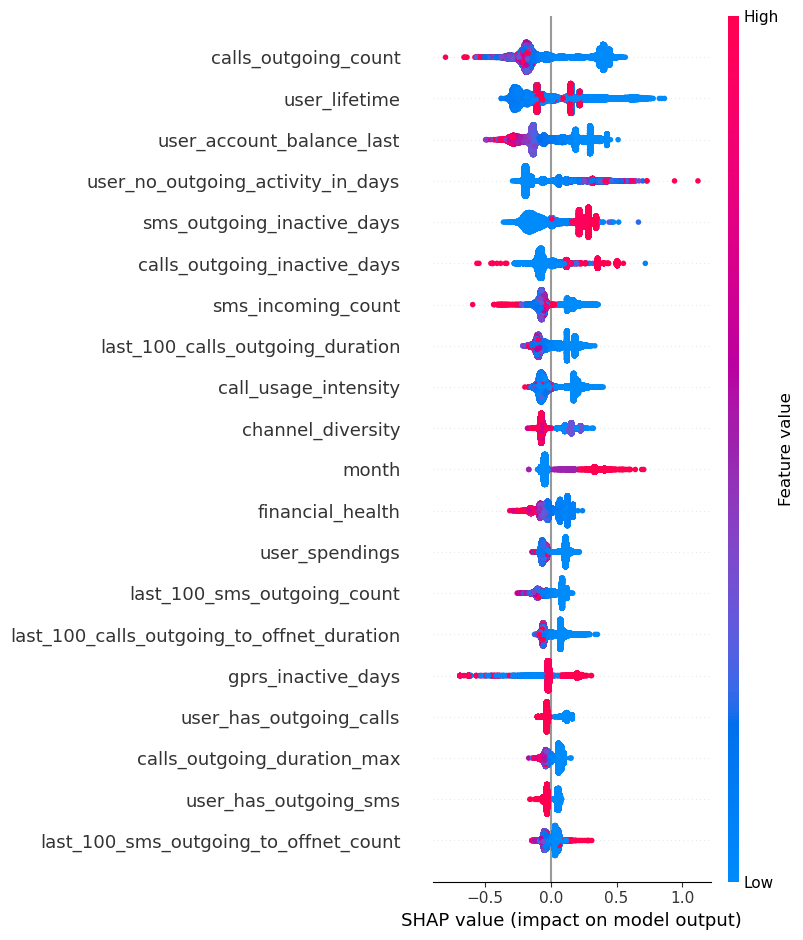

In [100]:
import shap

explainer = shap.TreeExplainer(best_catboost)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train, feature_names=X_train.columns)

## 8. NN Trial

### Exploring Deep Learning: DNN for Churn Prediction  

As a **bonus**, a **Deep Neural Network (DNN)** architecture was implemented to compare results with traditional models.  

#### Why DNN?  
- Can capture **complex, non-linear relationships** in user behavior.  
- Learns **deep feature representations**, potentially improving performance.  
- Handles **large-scale data** efficiently, leveraging hidden layers for better generalization.  

#### Key Insights:  
- **Compared to ensemble models**, DNN results were analyzed for improvements in **recall, precision, and overall AUC**.  
- **Further fine-tuning** may be required to optimize its performance against boosting models like **CatBoost, XGBoost, and LightGBM**.  


In [101]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

import tensorflow.keras.backend as K

In [102]:
classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)

class_weight_dict = {int(cls): weight for cls, weight in zip(classes, class_weights)}
print("Class Weights:", class_weight_dict)

Class Weights: {0: 0.6323821273400204, 1: 2.38847244732577}


In [103]:
X_train.shape

(47158, 50)

In [104]:
def nn_trial_model(input_dim):
    model = Sequential([
        Input(shape=(input_dim,)),

        Dense(256),
        LeakyReLU(alpha=0.1),
        BatchNormalization(),
        Dropout(0.2),

        Dense(128),
        LeakyReLU(alpha=0.1),
        BatchNormalization(),
        Dropout(0.2),

        Dense(64),
        LeakyReLU(alpha=0.1),

        Dense(32),
        LeakyReLU(alpha=0.1),


        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.0005),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    return model


nn_model = nn_trial_model(input_dim=X_train.shape[1])
nn_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               13056     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 256)               0         
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 128)               0         
                                                        

In [105]:
y_train = y_train.to_numpy() if hasattr(y_train, "to_numpy") else y_train
y_val = y_val.to_numpy() if hasattr(y_val, "to_numpy") else y_val
y_train = y_train.astype(int)
y_val = y_val.astype(int)

In [106]:
early_stopping = EarlyStopping(
    monitor='val_auc',
    patience=10,
    restore_best_weights=True,
    mode='max'
)

history = nn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100, batch_size=128, class_weight=class_weight_dict,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/100
369/369 [==============================] - 2s 4ms/step - loss: 0.4217 - accuracy: 0.8241 - auc: 0.8871 - val_loss: 0.3835 - val_accuracy: 0.8450 - val_auc: 0.8977
Epoch 2/100
369/369 [==============================] - 1s 3ms/step - loss: 0.4045 - accuracy: 0.8356 - auc: 0.8964 - val_loss: 0.3759 - val_accuracy: 0.8487 - val_auc: 0.9002
Epoch 3/100
369/369 [==============================] - 1s 3ms/step - loss: 0.4005 - accuracy: 0.8364 - auc: 0.8987 - val_loss: 0.3892 - val_accuracy: 0.8378 - val_auc: 0.9031
Epoch 4/100
369/369 [==============================] - 1s 3ms/step - loss: 0.3975 - accuracy: 0.8339 - auc: 0.9004 - val_loss: 0.3691 - val_accuracy: 0.8525 - val_auc: 0.8997
Epoch 5/100
369/369 [==============================] - 1s 3ms/step - loss: 0.3945 - accuracy: 0.8360 - auc: 0.9022 - val_loss: 0.3664 - val_accuracy: 0.8504 - val_auc: 0.9012
Epoch 6/100
369/369 [==============================] - 1s 3ms/step - loss: 0.3913 - accuracy: 0.8354 - auc: 0.9036 - val_loss

In [107]:
test_results = nn_model.evaluate(X_test, y_test)
print(f"Test Loss: {test_results[0]:.4f}, Test Accuracy: {test_results[1]:.4f}")

from sklearn.metrics import confusion_matrix, classification_report

y_pred_proba = nn_model.predict(X_test).flatten()
y_pred = (y_pred_proba > 0.5).astype(int)

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

188/188 [==============================] - 0s 1ms/step - loss: 0.3765 - accuracy: 0.8459 - auc: 0.9137
Test Loss: 0.3765, Test Accuracy: 0.8459
188/188 [==============================] - 0s 1ms/step
Confusion Matrix:
 [[3992  743]
 [ 180 1074]]
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.84      0.90      4735
           1       0.59      0.86      0.70      1254

    accuracy                           0.85      5989
   macro avg       0.77      0.85      0.80      5989
weighted avg       0.88      0.85      0.86      5989



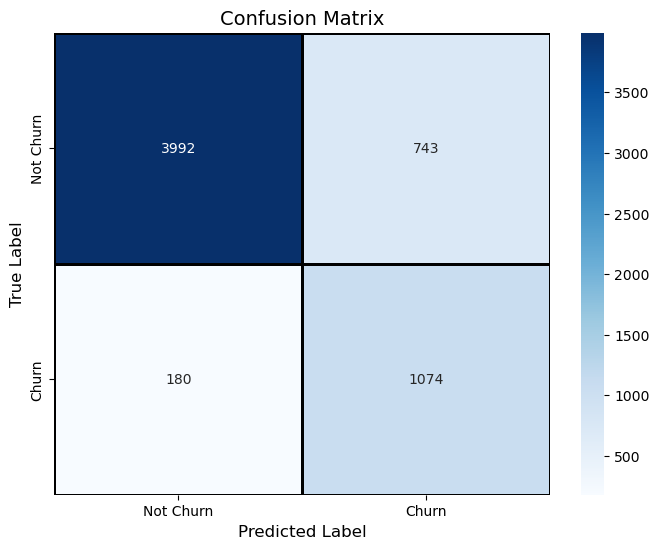

In [108]:
plot_confusion_matrix(y_test, y_pred)

# 🏆 Conclusion  

- Optuna Catboost Outperformed other models in terms of **Precision-Recall tradeoff, F1 Score, and ROC-AUC**.
- by Test Set ROC-AUC: 0.9200231066290089
- and with the accuracy of  0.88. Also Best Precision/Recall rate with that model.
- [Jump to BEST APPROACH RESULTS](#catboost-model-results)



# FURTHER IMPROVEMENTS
- Feature engineering can be **expanded** to improve model performance.  
- **Recursive Feature Elimination (RFE)** was attempted but had **high runtime** and minimal performance improvement due to **wide feature scaling**.  
- A more **optimal approach** might involve using **PCA** or other dimensionality reduction techniques.  

- **MLflow** or similar MLOps libraries can be integrated for better **experiment tracking, versioning, and deployment**.  
                                                         
- More **hyperparameter tuning** across different models can be explored.  
- Models like **SVM and Bayesian approaches** were tested but excluded due to **runtime complexity** and **high dimensionality constraints**.  

The next steps involve refining the **feature set, optimizing model selection**, and leveraging **MLOps** for scalability.  
